- `conda activate mri`
  - (created in `0_setup.ipynb`)

---

- `jupyter lab` => open this file

---

- Selected Jupyter kernel (`ms_classification`)
  - (created in `0_setup.ipynb`)

---

---

# Imports

In [1]:
import pandas as pd
import os, glob
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
import tensorflow as tf

import util
import conformal

2025-05-08 12:56:27.178725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746730587.199142 1386277 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746730587.205410 1386277 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 12:56:27.226128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

# Definitions

In [2]:
def get_corresponding_var_scans_from_baseline_scans(baseline_scan_dirs, var_scan_dirs):
    corresponding_scans = []
    for path in baseline_scan_dirs:
        ds, scn = path.split('/')[-2], path.split('/')[-1]
        # comprehension to cause error/stop if not all 
        # baseline train scans have corresponding var scan
        corresponding_var_scan = [x for x in var_scan_dirs if os.path.join(ds, scn) in x][0]
        corresponding_scans.append(corresponding_var_scan)
    return corresponding_scans

---

# Get Slices

In [3]:
matching_dirs = [d for d in glob.glob(os.path.expanduser('~/dissertation/data/MRI/_[MH]*/*'), recursive=True) if os.path.isdir(d)]

slice_folders_ms_muslim_15t = [x for x in matching_dirs if '_MS__Muslim_et_al_15T' in x]
slice_folders_healthy_ph15 = [x for x in matching_dirs if '_Healthy__IXI_15T_Guys' in x]
slice_folders_healthy_ge15 = [x for x in matching_dirs if '_Healthy__IXI_15T_IOP' in x]

print(f'slice_folders_ms_muslim_15t\n----------\nNumber of scans: {len(slice_folders_ms_muslim_15t)}\nNumber of slices: {len(slice_folders_ms_muslim_15t) * 43}')
print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_ms_muslim_15t])))}\n\n")

print(f'slice_folders_healthy_ph15\n----------\nNumber of scans: {len(slice_folders_healthy_ph15)}\nNumber of slices: {len(slice_folders_healthy_ph15) * 43}')
print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_healthy_ph15])))}\n\n")

print(f'slice_folders_healthy_ge15\n----------\nNumber of scans: {len(slice_folders_healthy_ge15)}\nNumber of slices: {len(slice_folders_healthy_ge15) * 43}')
print(f"Actual # slices:  {len(list(itertools.chain(*[glob.glob(os.path.join(folder, '*.png')) for folder in slice_folders_healthy_ge15])))}\n\n")

test_dirs = slice_folders_healthy_ge15 + slice_folders_healthy_ph15 + slice_folders_ms_muslim_15t

slice_folders_ms_muslim_15t
----------
Number of scans: 29
Number of slices: 1247
Actual # slices:  1247


slice_folders_healthy_ph15
----------
Number of scans: 319
Number of slices: 13717
Actual # slices:  13717


slice_folders_healthy_ge15
----------
Number of scans: 74
Number of slices: 3182
Actual # slices:  3182




---

# Model Predictions

In [15]:
variant_scans = {'baseline': test_dirs}
unseen_lbls = [1 if 'MS' in x else 0 for x in test_dirs]

for variant in glob.glob('_[bc]*/'):
    variant = variant.replace('/', '')
    variant_scans[variant] = glob.glob(os.path.join(variant, '_[MH]*/*'))

model_path = '_best_model__baseline__20250503.keras'
all_results = []

# for model_path in model_paths:
model = tf.keras.models.load_model(model_path)
model_name = os.path.basename(model_path).split('model_')[-1].split('_2025')[0].strip('_')

for variant in ['baseline',
                '_blurred_SD1', '_blurred_SD2', '_blurred_SD3', '_blurred_SD4', 
                '_contrast_adapthisteq', '_contrast_histeq', '_contrast_imadjust']:
    # Seeds/determinism for reproducibility
    util.set_seeds()
    
    test_dirs = get_corresponding_var_scans_from_baseline_scans(baseline_scan_dirs=test_dirs, 
                                                                var_scan_dirs=variant_scans[variant])

    with util.NoOutput():
        with tf.device('/CPU:0'):
            # Seeds/determinism for reproducibility
            util.set_seeds()
            df = util.predict_scans(test_dirs, unseen_lbls, model)
            df['variant_test_data'] = variant
            
    df['model'] = model_name    
    all_results.append(df)

In [5]:
final_df = pd.concat(all_results, ignore_index=True)
display(final_df.head(3))

final_df.to_csv('all_unseen_15T_variant_scans_preds_for_baseline_model.csv', index=False)
final_df.to_pickle('all_unseen_15T_variant_scans_preds_for_baseline_model.pkl')

,dataset,scan_id,slice_idx,class,predicted_class,is_correct,pred_prob_0,pred_prob_1,actual_class_pred_prob,variant_test_data,model
0,IXI_15T_IOP,0866,92,0,0,True,0.998547,0.001453,0.998547,baseline,baseline
1,IXI_15T_IOP,0866,93,0,0,True,0.999162,0.000838,0.999162,baseline,baseline
2,IXI_15T_IOP,0866,94,0,0,True,0.998944,0.001056,0.998944,baseline,baseline


---

# Read in Predictions

In [6]:
import pandas as pd
df = pd.read_pickle('all_unseen_15T_variant_scans_preds_for_baseline_model.pkl')

---

# Confusion Matrices

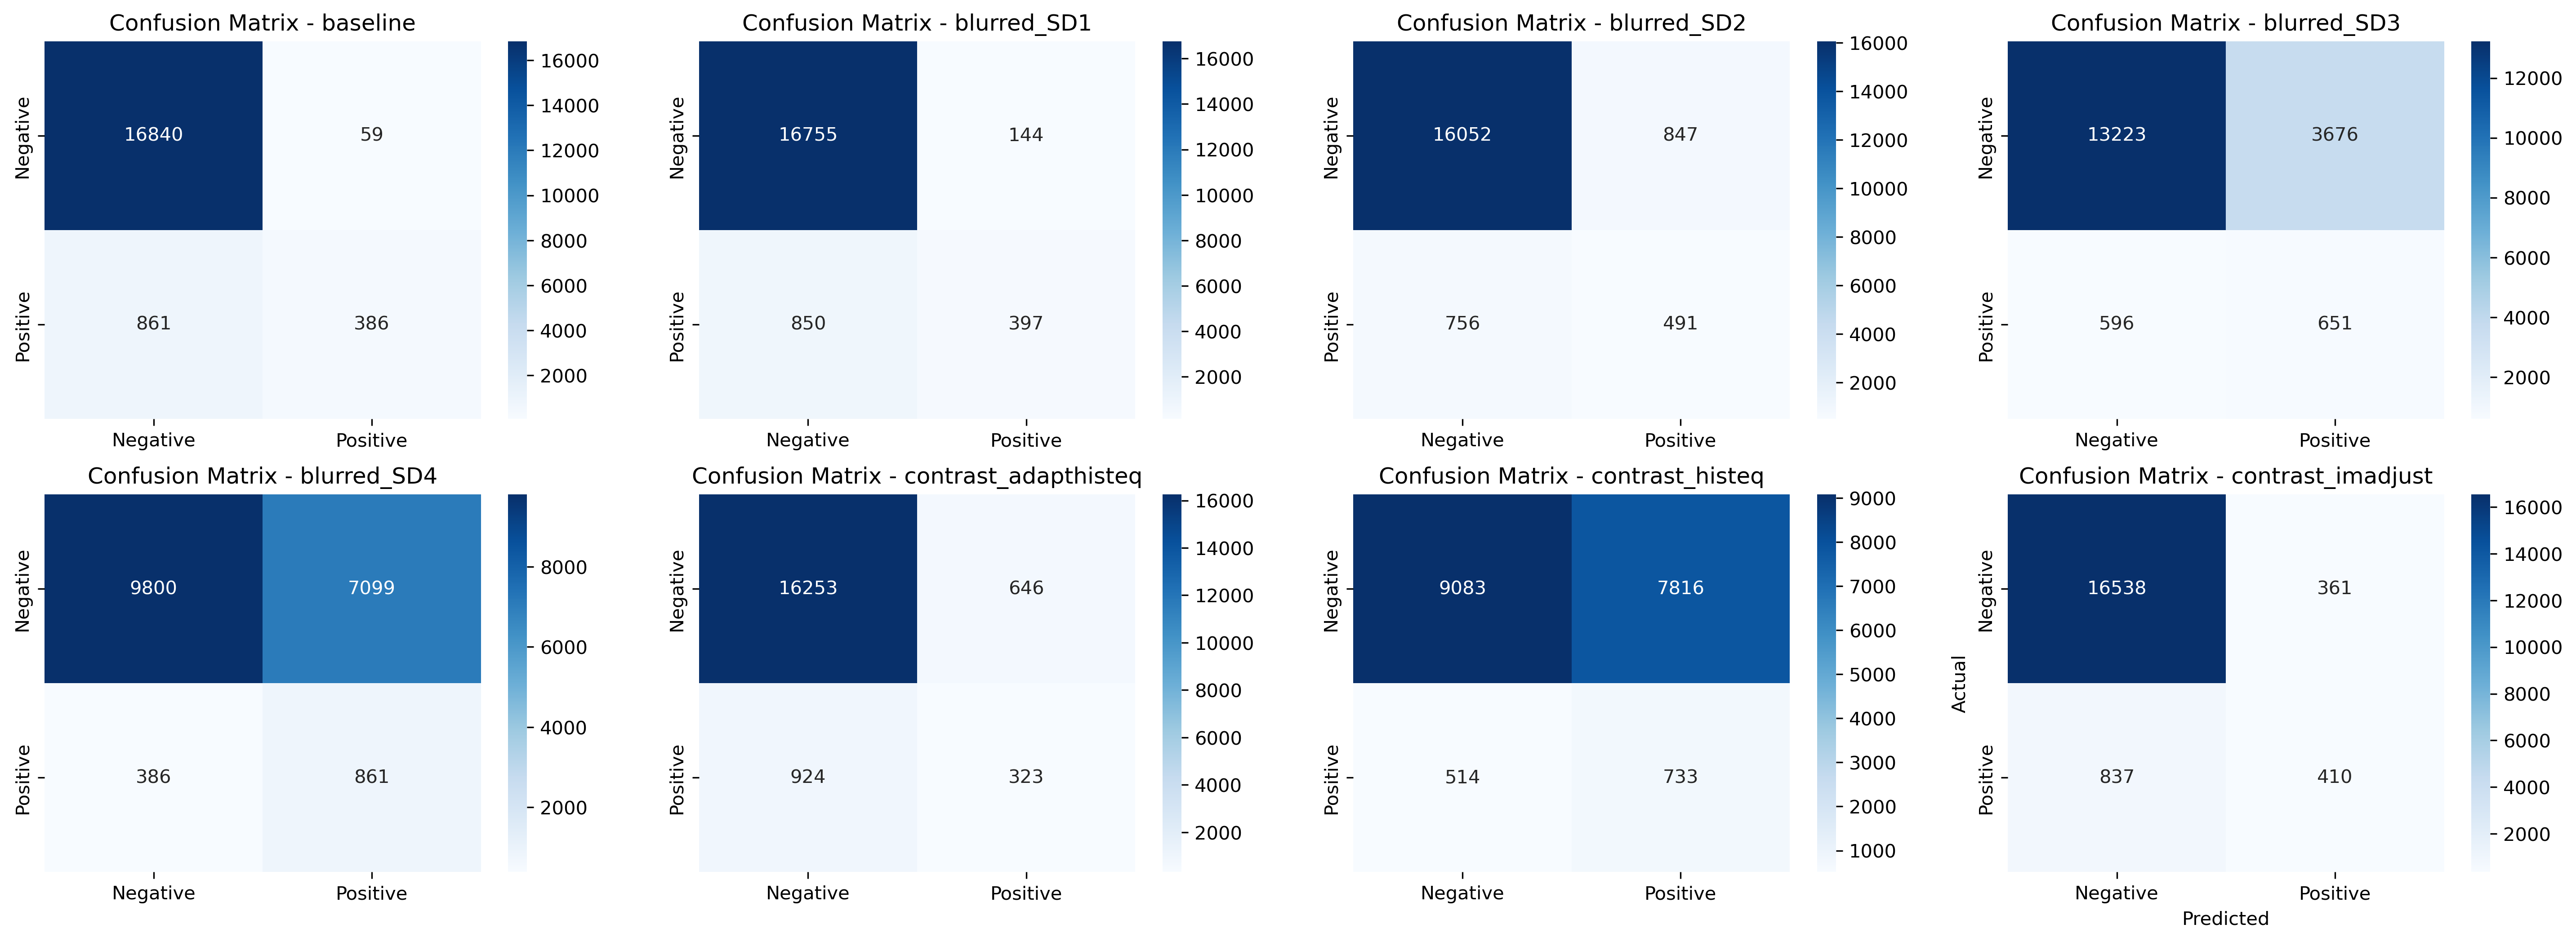

In [7]:
vs = df.variant_test_data.unique()
fig, axs = plt.subplots(2, 4, figsize=(24, 8), dpi=300)
for v, ax in zip(vs, axs.flatten()):
    y_true = df[(df.variant_test_data==v)]['class']
    y_pred = df[(df.variant_test_data==v)]['predicted_class']
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Visualize the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=ax)
    ax.set_title(f"Confusion Matrix - {v.strip('_')}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
        
# Save the figure with high resolution
# plt.savefig(f'overall_confusion_matrix__{mod}__publication_quality_plot.png', bbox_inches='tight')

plt.show()

---

# Accuracy, Precision, Recall, and F1 Score

In [8]:
results = {}
for v in df.variant_test_data.unique():
    vdf = df[(df.variant_test_data==v)]
    acc = vdf['is_correct'].mean()
    y_true = vdf['class']
    y_pred = vdf['predicted_class']
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    results[v] = [acc, precision_micro, recall_micro, f1_micro]
display(pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score']).round(3))

,baseline,_blurred_SD1,_blurred_SD2,_blurred_SD3,_blurred_SD4,_contrast_adapthisteq,_contrast_histeq,_contrast_imadjust
Accuracy,0.949,0.945,0.912,0.765,0.588,0.913,0.541,0.934
Precision,0.867,0.734,0.367,0.150,0.108,0.333,0.086,0.532
Recall,0.310,0.318,0.394,0.522,0.690,0.259,0.588,0.329
F1 Score,0.456,0.444,0.380,0.234,0.187,0.292,0.150,0.406


---

# Micro-Averaged ROC Curve

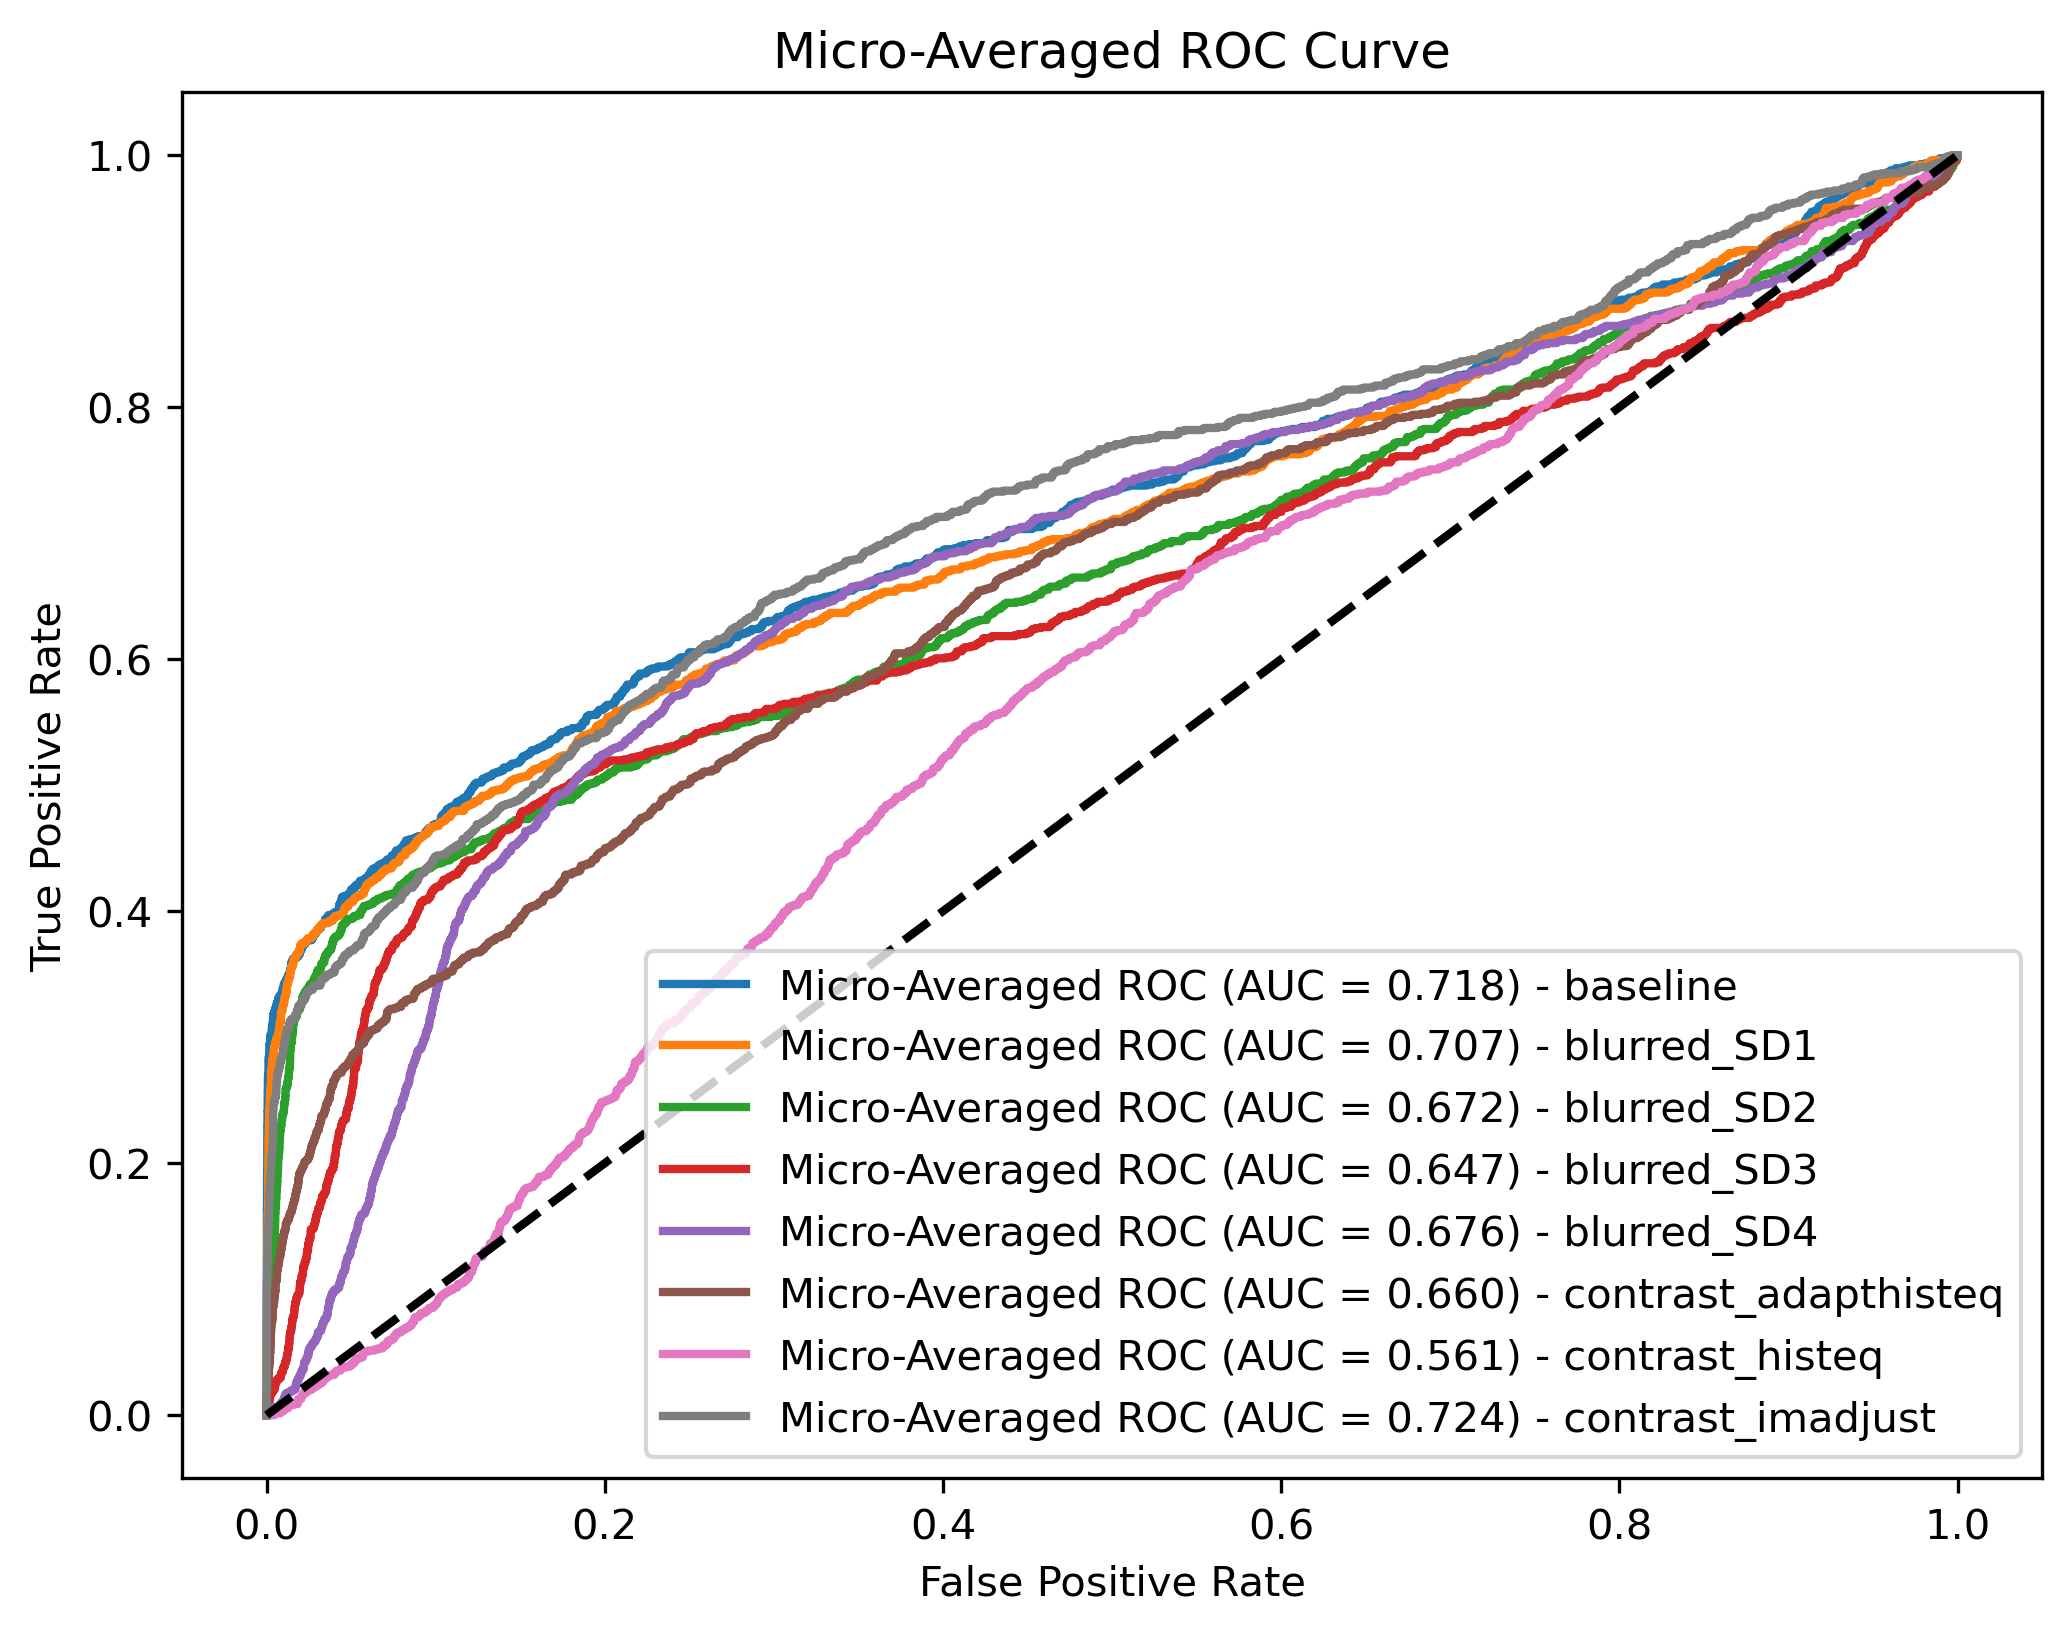

In [9]:
# ROC
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
for v in df.variant_test_data.unique():
    y_true = df[(df.variant_test_data==v)]['class']
    y_score = df[(df.variant_test_data==v)]['pred_prob_1']

    # Compute micro-average ROC curve and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true, y_score)
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Plot the micro-average ROC curve
    ax.plot(fpr_micro, tpr_micro, label=f"Micro-Averaged ROC (AUC = {roc_auc_micro:.3f}) - {v.strip('_')}", lw=2)

# Plot diagonal line
ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Micro-Averaged ROC Curve')
ax.legend()

# Save the figure with high resolution
# plt.savefig(f'ROC_curve__{mod}__publication_quality_plot.png', bbox_inches='tight')

plt.show()

---

# Accuracy by `variant_test_data` (and by `class`)

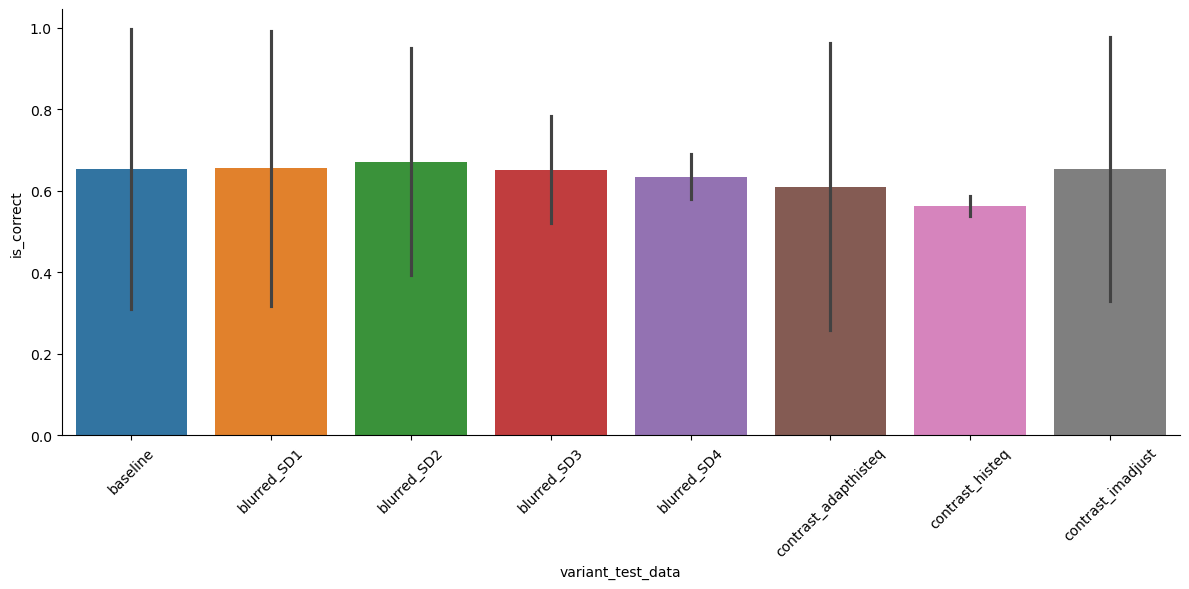

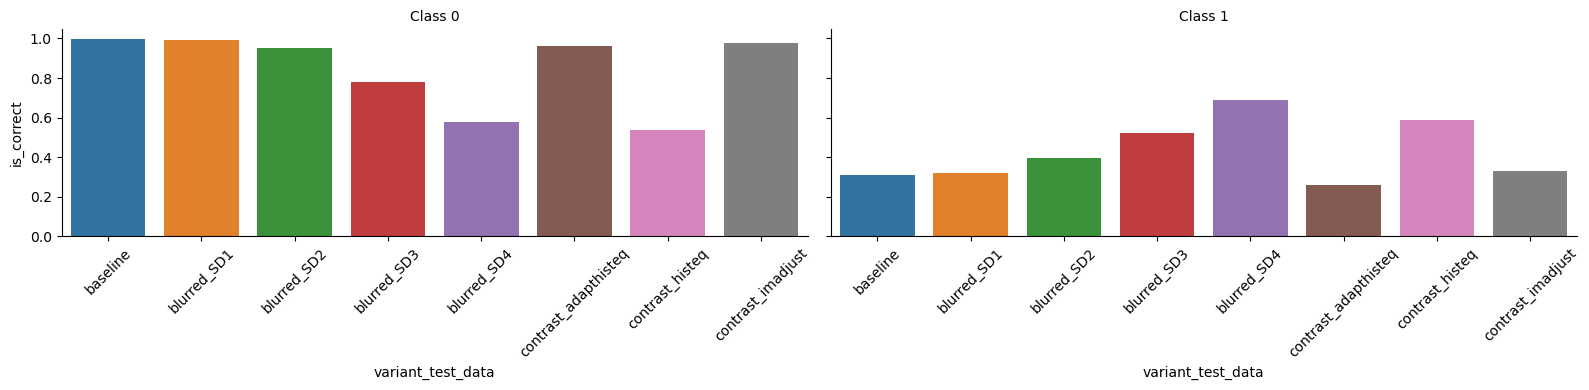

In [10]:
temp = df.copy()
temp['variant_test_data'] = temp['variant_test_data'].apply(lambda x: x.strip('_'))
grouped = temp.groupby(['variant_test_data', 'class'])['is_correct'].mean().reset_index()

g = sns.catplot(data=grouped, x='variant_test_data', y='is_correct', hue='variant_test_data', kind='bar', height=6, aspect=2)
g.set_xticklabels(rotation=45)
g.set_titles('Class {col_name}')
g.fig.tight_layout()

g = sns.catplot(data=grouped, x='variant_test_data', y='is_correct', hue='variant_test_data', col='class', kind='bar', height=4, aspect=2)
g.set_xticklabels(rotation=45)
g.set_titles('Class {col_name}')
g.fig.tight_layout()

---

---

---

---

In [11]:
for mod in df.model.unique():
    print(mod)
    y_true = df[(df.variant_test_data=='baseline') & (df.model==mod)]['class']
    y_pred = df[(df.variant_test_data=='baseline') & (df.model==mod)]['predicted_class']
            
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    print('---')
    print('Precision:', f'{precision_micro*100:.1f}%')
    print('Recall:   ', f'{recall_micro*100:.1f}%')
    print('F1 Score: ', f'{f1_micro*100:.1f}%')
    print('---')
        
    plt.show()

baseline
---
Precision: 86.7%
Recall:    31.0%
F1 Score:  45.6%
---


baseline


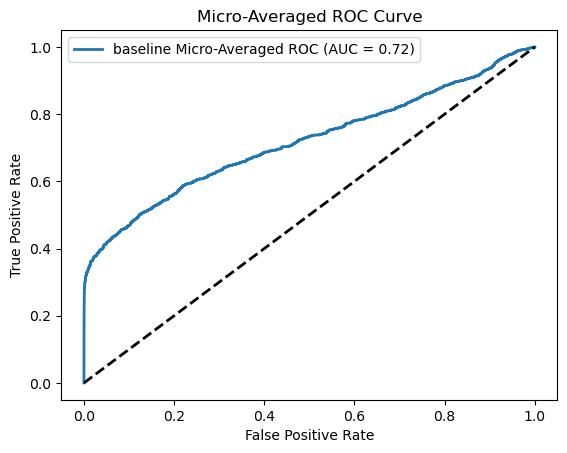

<Figure size 2400x1800 with 0 Axes>

In [12]:
fig, ax = plt.subplots()

for mod in df.model.unique():
    print(mod)
    y_true = df[(df.variant_test_data=='baseline') & (df.model==mod)]['class']
    y_score = df[(df.variant_test_data=='baseline') & (df.model==mod)]['pred_prob_1']

    # Compute micro-average ROC curve and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true, y_score)
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Plot the micro-average ROC curve
    plt.figure(figsize=(8, 6), dpi=300)
    ax.plot(fpr_micro, tpr_micro, label=f'{mod} Micro-Averaged ROC (AUC = {roc_auc_micro:.2f})', lw=2)

# Plot diagonal line
ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Micro-Averaged ROC Curve')
ax.legend()

# Save the figure with high resolution
# plt.savefig(f'ROC_curve__{mod}__publication_quality_plot.png', bbox_inches='tight')

plt.show()

In [13]:
df.variant_test_data.unique()

array(['baseline', '_blurred_SD1', '_blurred_SD2', '_blurred_SD3',
       '_blurred_SD4', '_contrast_adapthisteq', '_contrast_histeq',
       '_contrast_imadjust'], dtype=object)

baseline + baseline
baseline + _blurred_SD1
baseline + _blurred_SD2
baseline + _blurred_SD3
baseline + _blurred_SD4
baseline + _contrast_adapthisteq
baseline + _contrast_histeq
baseline + _contrast_imadjust


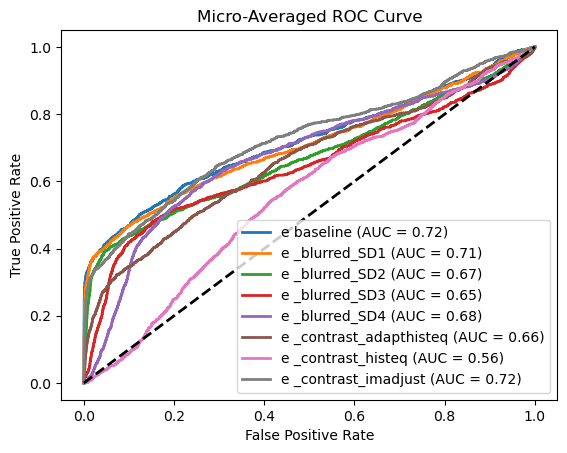

In [14]:
for mod in df.model.unique():
    fig, ax = plt.subplots()
    for v in df.variant_test_data.unique():
        print(mod, '+', v)
        y_true = df[(df.variant_test_data==v) & (df.model==mod)]['class']
        y_score = df[(df.variant_test_data==v) & (df.model==mod)]['pred_prob_1']
    
        # Compute micro-average ROC curve and AUC
        fpr_micro, tpr_micro, _ = roc_curve(y_true, y_score)
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        # Plot the micro-average ROC curve
        ax.plot(fpr_micro, tpr_micro, label=f'{mod[-1]} {v} (AUC = {roc_auc_micro:.2f})', lw=2)
    
    # Plot diagonal line
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Plot formatting
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Micro-Averaged ROC Curve')
    ax.legend()
    
    # Save the figure with high resolution
    # plt.savefig(f'ROC_curve__{mod}__publication_quality_plot.png', bbox_inches='tight')
    
    plt.show()